# <center> **Titanic Competition** </center>

**Link Competitions:** [Titanic - Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic)

**Vũ Khánh Nam**

***
## Import

In [1]:
import hashlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV , StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, log_loss

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


In [2]:
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')
PassengerID_test = df_test["PassengerId"]

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing

#### Training set

In [3]:
df_train = df_train.drop(columns= ["Name",  "PassengerId"])

df_train["Cabin"] = df_train["Cabin"][:].str[0]
df_train["Cabin"].fillna("O", inplace=True)

df_train = df_train.replace({"Ticket": {"LINE": "LINE 0" }})
df_train["Ticket_num"] = df_train["Ticket"].str.split(" ").str[-1].astype(int)

df_train["Ticket"] = df_train["Ticket"].str.split(" ").str[0].apply(lambda x: x if x.isnumeric() == False else "None")
df_train["Ticket"] = df_train["Ticket"].str.replace("/", "",regex=True).str.replace(".", "",regex=True)

df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
0,0,3,male,22.0,1,0,A5,7.2500,O,S,21171
1,1,1,female,38.0,1,0,PC,71.2833,C,C,17599
2,1,3,female,26.0,0,0,STONO2,7.9250,O,S,3101282
3,1,1,female,35.0,1,0,None,53.1000,C,S,113803
4,0,3,male,35.0,0,0,None,8.0500,O,S,373450
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,None,13.0000,O,S,211536
887,1,1,female,19.0,0,0,None,30.0000,B,S,112053
888,0,3,female,NaN,1,2,WC,23.4500,O,S,6607
889,1,1,male,26.0,0,0,None,30.0000,C,C,111369


### Test set

In [4]:
df_test = df_test.drop(columns= ["Name", "PassengerId"])
df_test["Cabin"] = df_test["Cabin"][:].str[0]
df_test["Cabin"].fillna("O", inplace=True)

df_test = df_test.replace({"Ticket": {"LINE": "LINE 0" }})
df_test["Ticket_num"] = df_test["Ticket"].str.split(" ").str[-1].astype(int)

df_test["Ticket"] = df_test["Ticket"].str.split(" ").str[0].apply(lambda x: x if x.isnumeric() == False else "None")
df_test["Ticket"] = df_test["Ticket"].str.replace("/", "",regex=True).str.replace(".", "",regex=True)

df_test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
0,3,male,34.5,0,0,None,7.8292,O,Q,330911
1,3,female,47.0,1,0,None,7.0000,O,S,363272
2,2,male,62.0,0,0,None,9.6875,O,Q,240276
3,3,male,27.0,0,0,None,8.6625,O,S,315154
4,3,female,22.0,1,1,None,12.2875,O,S,3101298
...,...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,A5,8.0500,O,S,3236
414,1,female,39.0,0,0,PC,108.9000,C,C,17758
415,3,male,38.5,0,0,SOTONOQ,7.2500,O,S,3101262
416,3,male,NaN,0,0,None,8.0500,O,S,359309


### Disturbance handler

In [5]:
def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

**Age**

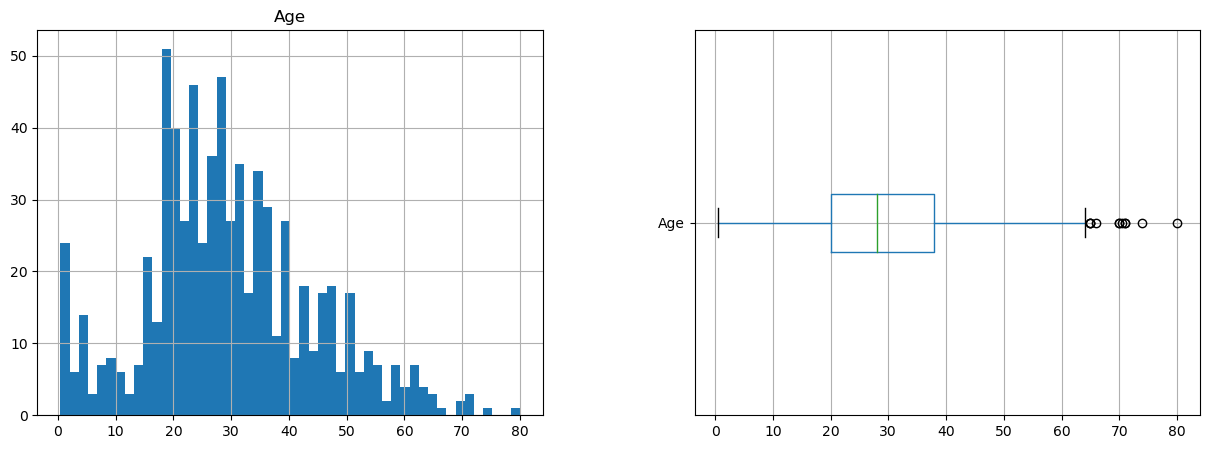

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train[["Age"]].hist(bins=50, ax=axes[0]);
df_train[["Age"]].boxplot(ax=axes[1], vert=False);

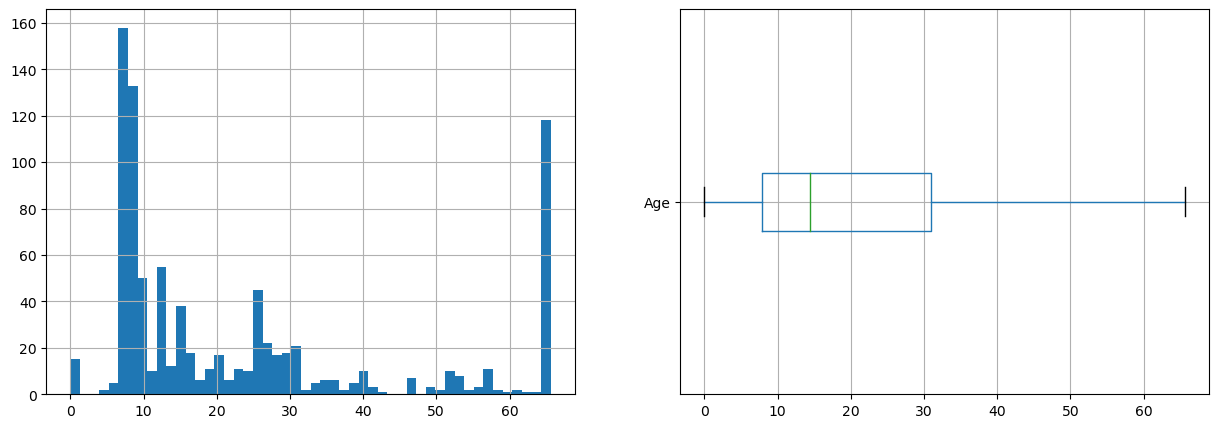

In [7]:
df_train["Age"] = BoxplotOutlierClipper().fit_transform(df_train["Fare"])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train["Age"].hist(bins=50, ax=axes[0]);
df_train["Age"].to_frame().boxplot(ax=axes[1], vert=False);

**SibSp**

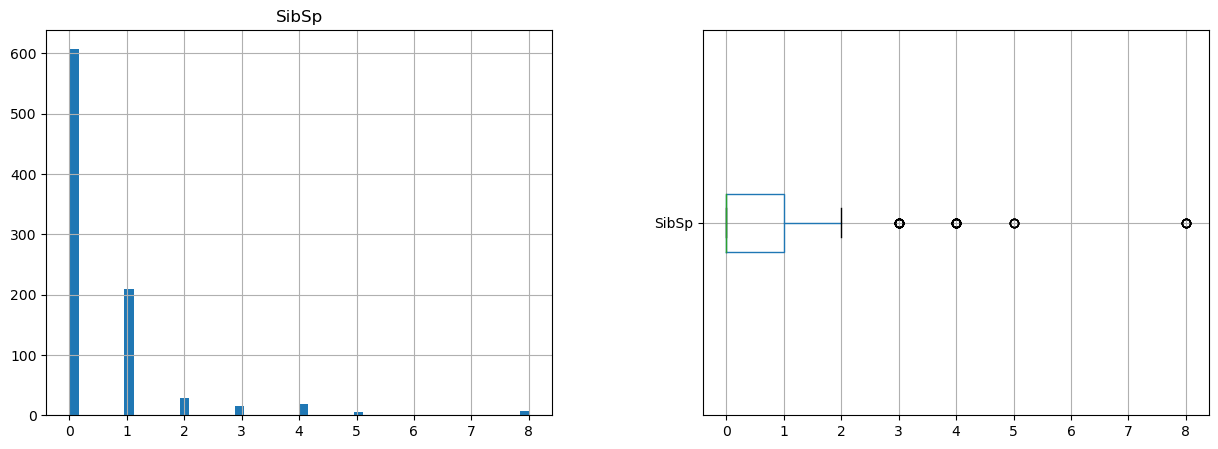

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train[["SibSp"]].hist(bins=50, ax=axes[0]);
df_train[["SibSp"]].boxplot(ax=axes[1], vert=False);

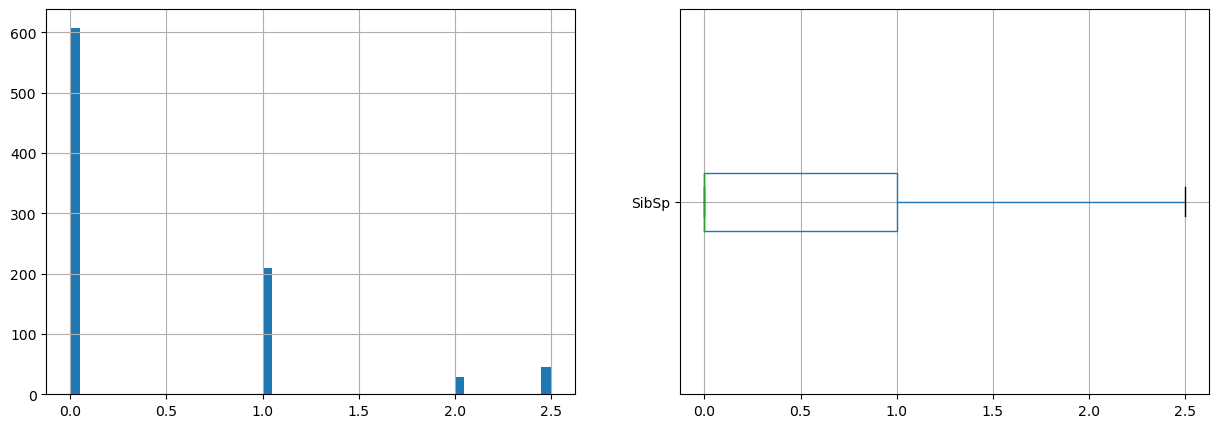

In [9]:
df_train["SibSp"] = BoxplotOutlierClipper().fit_transform(df_train["SibSp"])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train["SibSp"].hist(bins=50, ax=axes[0]);
df_train["SibSp"].to_frame().boxplot(ax=axes[1], vert=False);

**Parch**

In [10]:
class ZscoreOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, z_threshold: float = 3):
        self.z_threshold = z_threshold
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        mean = X.mean()
        std = X.std()
        self.lower = mean - self.z_threshold * std
        self.upper = mean + self.z_threshold * std
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

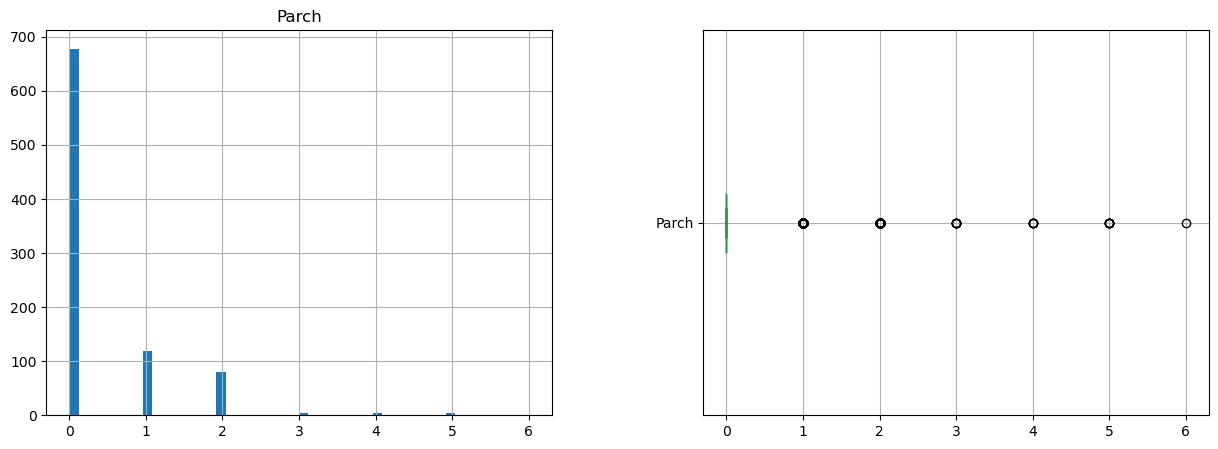

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train[["Parch"]].hist(bins=50, ax=axes[0]);
df_train[["Parch"]].boxplot(ax=axes[1], vert=False);

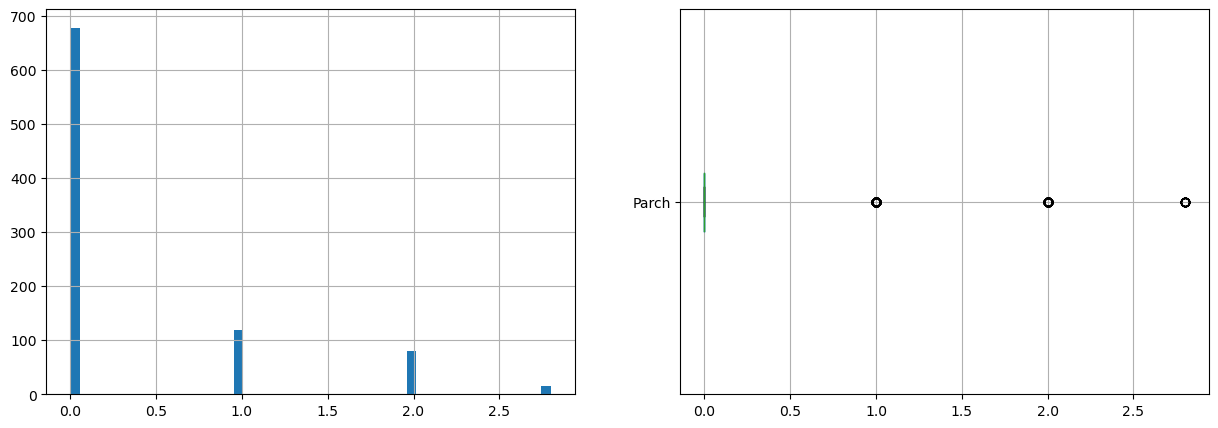

In [12]:
df_train["Parch"] = ZscoreOutlierClipper().fit_transform(df_train["Parch"])
# df_train["Parch"] = BoxplotOutlierClipper().fit_transform(df_train["Parch"])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train["Parch"].hist(bins=50, ax=axes[0]);
df_train["Parch"].to_frame().boxplot(ax=axes[1], vert=False);

**FARE**

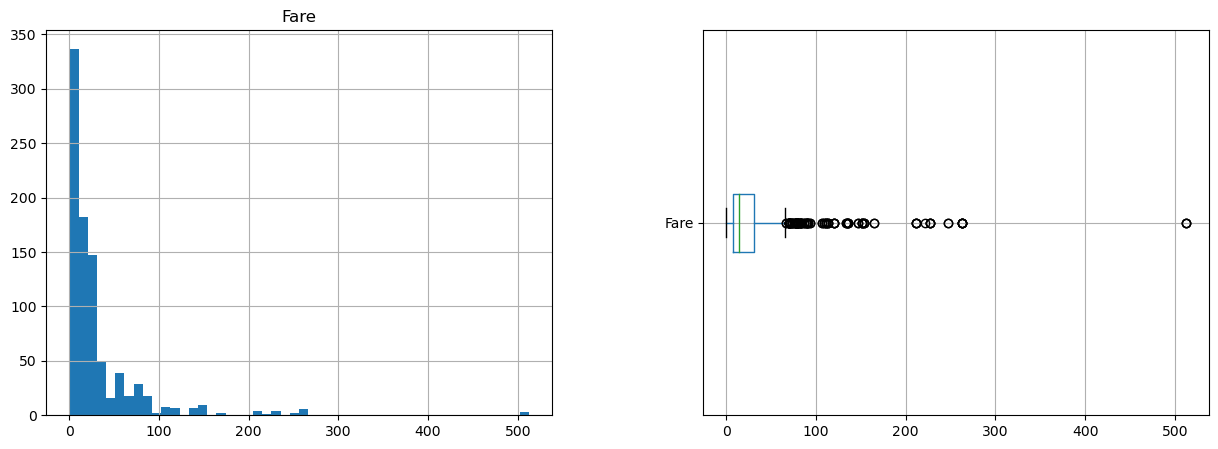

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train[["Fare"]].hist(bins=50, ax=axes[0]);
df_train[["Fare"]].boxplot(ax=axes[1], vert=False);

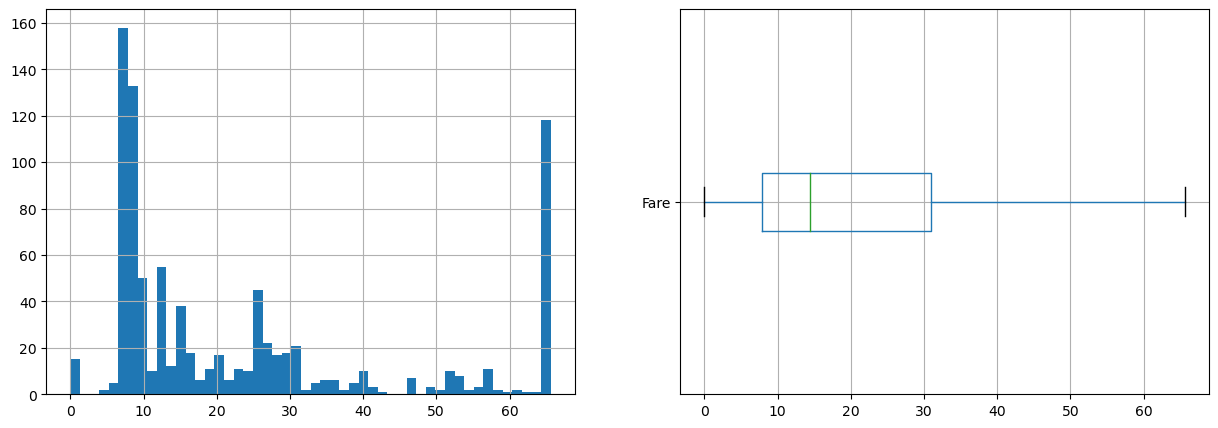

In [14]:
df_train["Fare"] = BoxplotOutlierClipper().fit_transform(df_train["Fare"])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
df_train["Fare"].hist(bins=50, ax=axes[0]);
df_train["Fare"].to_frame().boxplot(ax=axes[1], vert=False);

In [15]:
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
0,0,3,male,7.2500,1.0,0.0,A5,7.2500,O,S,21171
1,1,1,female,65.6344,1.0,0.0,PC,65.6344,C,C,17599
2,1,3,female,7.9250,0.0,0.0,STONO2,7.9250,O,S,3101282
3,1,1,female,53.1000,1.0,0.0,None,53.1000,C,S,113803
4,0,3,male,8.0500,0.0,0.0,None,8.0500,O,S,373450
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,13.0000,0.0,0.0,None,13.0000,O,S,211536
887,1,1,female,30.0000,0.0,0.0,None,30.0000,B,S,112053
888,0,3,female,23.4500,1.0,2.0,WC,23.4500,O,S,6607
889,1,1,male,30.0000,0.0,0.0,None,30.0000,C,C,111369


### Fill NaN + Hashing

In [16]:
label_encoder_Sex = preprocessing.LabelEncoder()
label_encoder_Sex.fit(df_train["Sex"])

label_encoder_Cabin = preprocessing.LabelEncoder()
label_encoder_Cabin.fit(df_train["Cabin"])

label_encoder_Embarked = preprocessing.LabelEncoder()
label_encoder_Embarked.fit(df_train["Embarked"])

scaler = StandardScaler()
scaler.fit(df_train[["Ticket_num",]])

StandardScaler()

In [17]:
def hash_modulo(val, mod):
    md5 = hashlib.md5()  # can be other deterministic hash functions
    md5.update(str(val).encode())
    return int(md5.hexdigest(), 16) % mod


class FeatureHasher(BaseEstimator, TransformerMixin):
    def __init__(self, num_buckets: int):
        self.num_buckets = num_buckets

    def fit(self, X: pd.Series):
        return self

    def transform(self, X: pd.Series):
        return X.apply(lambda x: hash_modulo(x, self.num_buckets))


In [18]:
fh = FeatureHasher(num_buckets=1000)
fh.fit(df_train["Ticket"])

FeatureHasher(num_buckets=1000)

#### Train set

In [19]:
print(f"Number of Ticket_num: {len(df_train['Ticket_num'].unique())}")
df_train.isnull().sum()

Number of Ticket_num: 679


Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin         0
Embarked      2
Ticket_num    0
dtype: int64

In [20]:
df_train["Sex"] = label_encoder_Sex.transform(df_train["Sex"])

df_train["Age"].fillna(df_train["Age"].mean(), inplace=True)

df_train["Ticket"] = fh.transform(df_train["Ticket"])

df_train["Cabin"] = label_encoder_Cabin.transform(df_train["Cabin"])

df_train["Embarked"].fillna(df_train["Embarked"].value_counts().idxmax(), inplace=True)

df_train["Embarked"] = label_encoder_Embarked.transform(df_train["Embarked"])


df_train[["Ticket_num"]] = scaler.transform(df_train[["Ticket_num",]])

df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
0,0,3,1,7.2500,1.0,0.0,234,7.2500,7,2,-0.420410
1,1,1,0,65.6344,1.0,0.0,165,65.6344,2,0,-0.425854
2,1,3,0,7.9250,0.0,0.0,445,7.9250,7,2,4.274382
3,1,1,0,53.1000,1.0,0.0,316,53.1000,2,2,-0.279217
4,0,3,1,8.0500,0.0,0.0,316,8.0500,7,2,0.116544
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,13.0000,0.0,0.0,316,13.0000,7,2,-0.130250
887,1,1,0,30.0000,0.0,0.0,316,30.0000,1,2,-0.281885
888,0,3,0,23.4500,1.0,2.0,309,23.4500,7,2,-0.442609
889,1,1,1,30.0000,0.0,0.0,316,30.0000,2,0,-0.282927


In [21]:
df_train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin         0
Embarked      0
Ticket_num    0
dtype: int64

#### Test set

In [22]:
print(f"Number of Ticket_num: {len(df_test['Ticket_num'].unique())}")
df_test.isnull().sum()

Number of Ticket_num: 362


Pclass         0
Sex            0
Age           86
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
Ticket_num     0
dtype: int64

In [23]:
df_test["Age"].fillna(df_train["Age"].mean(), inplace=True)

df_test["Fare"].fillna(df_train["Fare"].mean(), inplace=True)

df_test["Sex"] = label_encoder_Sex.transform(df_test["Sex"])

df_test["Ticket"] = fh.transform(df_test["Ticket"])

df_test["Cabin"] = label_encoder_Cabin.transform(df_test["Cabin"])

df_test["Embarked"] = label_encoder_Embarked.transform(df_test["Embarked"])

df_test[["Ticket_num"]] = scaler.transform(df_test[["Ticket_num",]])

df_test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
0,3,1,34.500000,0,0,316,7.8292,7,1,0.051705
1,3,0,47.000000,1,0,316,7.0000,7,2,0.101030
2,2,1,62.000000,0,0,316,9.6875,7,1,-0.086444
3,3,1,27.000000,0,0,316,8.6625,7,2,0.027687
4,3,0,22.000000,1,1,316,12.2875,7,2,4.274406
...,...,...,...,...,...,...,...,...,...,...
413,3,1,24.046813,0,0,234,8.0500,7,2,-0.447747
414,1,0,39.000000,0,0,165,108.9000,2,0,-0.425612
415,3,1,38.500000,0,0,802,7.2500,7,2,4.274351
416,3,1,24.046813,0,0,316,8.0500,7,2,0.094990


## Correlation map

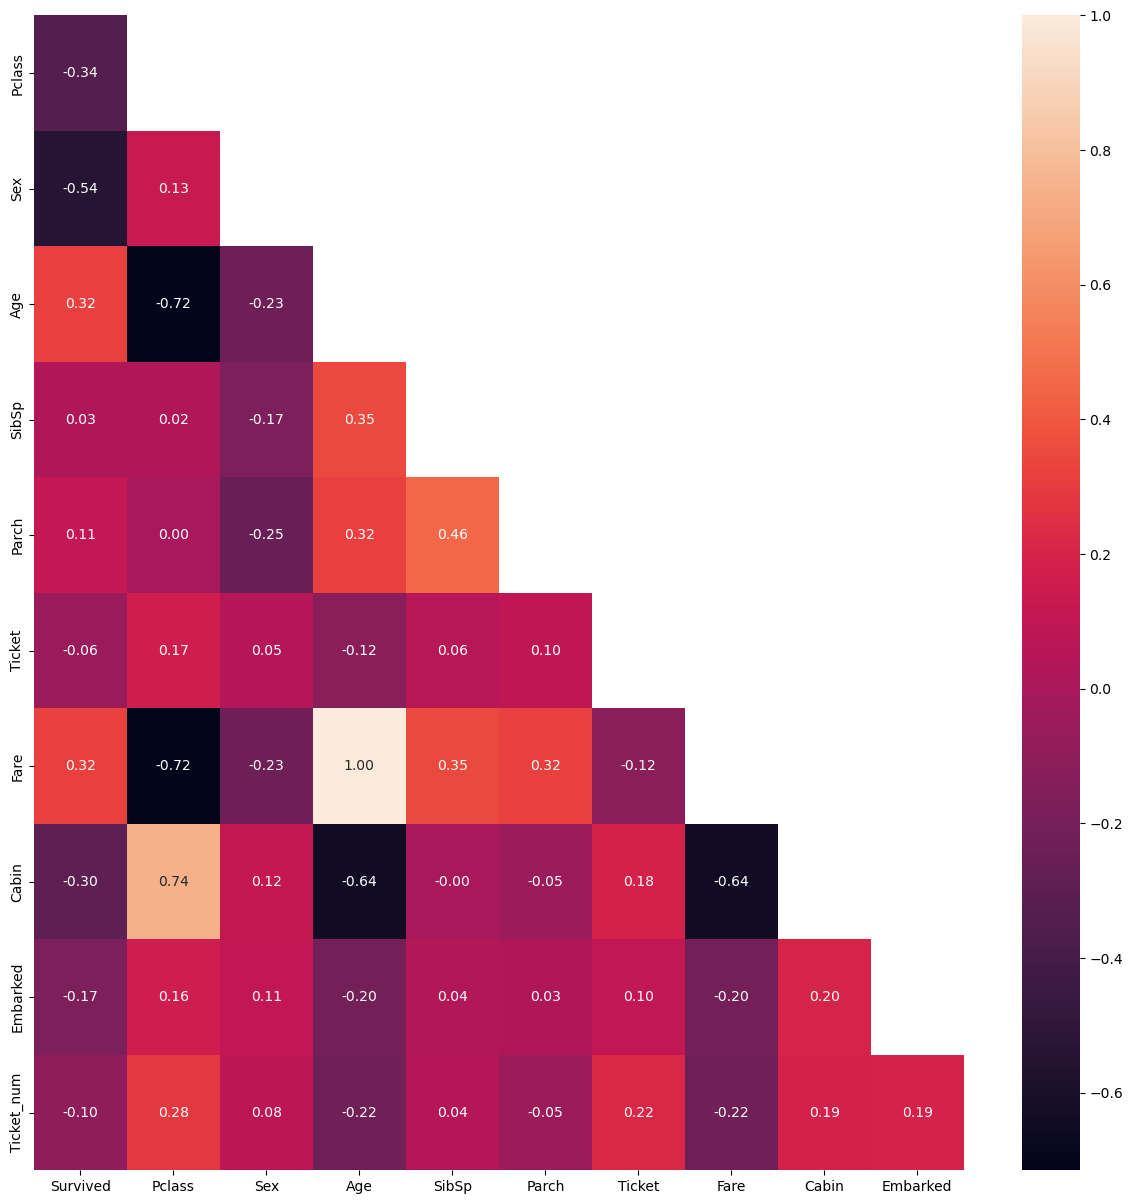

In [24]:
corr = df_train.corr()
one_corr = np.ones_like(corr, dtype=bool)

mask = np.triu(one_corr)
mask = mask[1:, :-1]
corr = corr.iloc[1:, :-1]

plt.figure(figsize=(15, 15))
sns.heatmap(data= corr, mask= mask, annot=True, fmt='.2f')
plt.show()

## Split Train_set, Y_label

In [25]:
X_train = df_train.drop("Survived", axis= 1)
y_train = df_train["Survived"]

print("X_train:", X_train.shape, "  y_train:", y_train.shape,)

X_train: (891, 10)   y_train: (891,)


## Training

### Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators= 100 ,max_depth= 3,min_samples_leaf= 1, min_samples_split= 2, random_state = 498)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)

acc_train = accuracy_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

print("accuracy_score_train:", acc_train, "     f1_train:",f1_train)

accuracy_score_train: 0.8271604938271605      f1_train: 0.7326388888888888


## Predict

In [28]:
y_pred = rf.predict(df_test)
output = pd.DataFrame({'PassengerId': PassengerID_test, 'Survived': y_pred})
output.to_csv('submission.csv', index=False)
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
